In [1]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1024)

In [16]:
# 定义线性模型和Sigmoid函数

class Linear:
    
    def __init__(self, in_features, out_features, bias=True):
        '''
        模型参数初始化
        需要注意的是，此次故意没做参数初始化的优化
        '''
        self.weight = torch.randn((in_features, out_features), requires_grad=True)   # (in_features, out_features)
        self.bias = torch.randn(out_features, requires_grad=True) if bias else None  # (             out_features)
        
    def __call__(self, x):
        #           x: (B, in_features)
        # self.weight:    (in_features, out_features)
        self.out = x @ self.weight  # (B, out_features)
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        '''
        返回线性模型的参数，主要用于参数迭代更新
        由于PyTorch的计算单元就是张量，
        所以此次只需将不同参数简单合并成列表即可
        '''
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]


class Sigmoid:
    
    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out
    
    def parameters(self):
        '''
        Sigmoid函数没有模型参数
        '''
        return []

In [17]:
class Sequential:
    
    def __init__(self, layers):
        # layers表示的模型组件，比如线性模型，比如sigmoid
        self.layers = layers
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # k = []
        # for layer in self.layers:
        #     for p in layer.parameters():
        #         k.append(p)
        return [p for layer in self.layers for p in layer.parameters()]
    
    def predict_proba(self, x):
        # 计算概率预测
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).float()
        logits = self(x)
        self.prob = F.softmax(logits, dim=-1).detach().numpy()
        return self.prob

In [7]:
# x: (B, 2)
# mlp: [4, 4, 2]
model = Sequential([
    Linear(2, 4), Sigmoid(),  # (B, 4)
    Linear(4, 4), Sigmoid(),  # (B, 4)
    Linear(4, 2)
])
x = torch.randn(3, 2)
model(x)

tensor([[-0.5756,  0.0729],
        [-0.5902,  0.0307],
        [-0.5812,  0.0562]])

In [8]:
model.predict_proba(x)

array([[0.34332383, 0.6566762 ],
       [0.34957516, 0.6504248 ],
       [0.34582347, 0.65417653]], dtype=float32)

In [9]:
def draw_data(data):
    '''
    将数据可视化
    '''
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    x, y = data
    label1 = x[y > 0]
    ax.scatter(label1[:, 0], label1[:, 1], marker='o')
    label0 = x[y == 0]
    ax.scatter(label0[:, 0], label0[:, 1], marker='^', color='k')
    return ax

def draw_model(ax, model):
    '''
    将模型的分离超平面可视化
    '''
    x1 = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    x2 = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
    x1, x2 = np.meshgrid(x1, x2)
    y = model.predict_proba(np.c_[x1.ravel(), x2.ravel()])[:, 1]
    y = y.reshape(x1.shape)
    ax.contourf(x1, x2, y, levels=[0, 0.5], colors=['gray'], alpha=0.4)
    return ax

<Axes: >

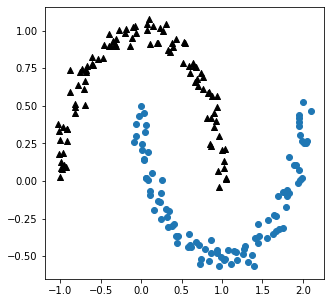

In [10]:
data = make_moons(200, noise=0.05)
draw_data(data)

In [18]:
batch_size = 20
max_steps = 40000
x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
learning_rate = 0.1
model = Sequential([
    Linear(2, 4), Sigmoid(),  # (B, 4)
    Linear(4, 4), Sigmoid(),  # (B, 4)
    Linear(4, 2)
])
lossi = []

for t in range(max_steps):
    ix = (t * batch_size) % len(x)
    xx = x[ix: ix + batch_size]
    yy = y[ix: ix + batch_size]
    logits = model(xx)
    loss = F.cross_entropy(logits, yy)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p -= learning_rate * p.grad
            p.grad = None
    lossi.append(loss.item())

<Axes: >

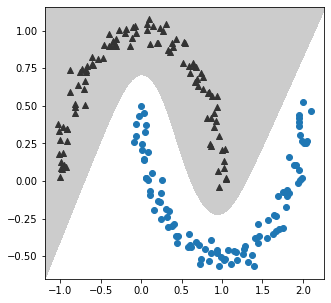

In [20]:
ax = draw_data(data)
draw_model(ax, model)

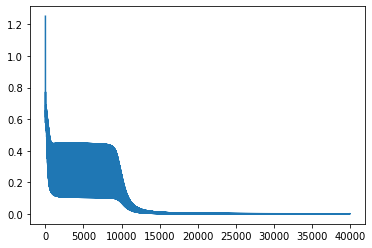

In [21]:
plt.plot(lossi)

In [24]:
torch.linspace(1, 10, 10).view(-1, 2).mean(dim=-1)

tensor([1.5000, 3.5000, 5.5000, 7.5000, 9.5000])

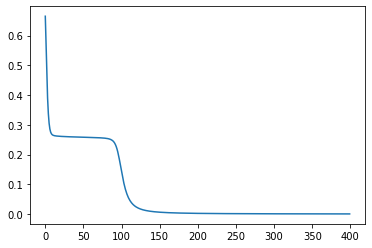

In [25]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(dim=-1))